[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\abdel\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


News Dataset Info:
<class 'pandas.core.frame.DataFrame'>
Index: 20000 entries, 1201723 to 657430
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype              
---  ------      --------------  -----              
 0   Unnamed: 0  20000 non-null  int64              
 1   headline    20000 non-null  object             
 2   url         20000 non-null  object             
 3   publisher   20000 non-null  object             
 4   date        19185 non-null  datetime64[ns, UTC]
 5   stock       20000 non-null  object             
 6   date_only   19185 non-null  datetime64[ns]     
dtypes: datetime64[ns, UTC](1), datetime64[ns](1), int64(1), object(4)
memory usage: 1.2+ MB
None
Loaded news data in 10.40 seconds
Sentiment analysis completed in 5.02 seconds

Correlation between sentiment and AAPL daily returns: 0.0238


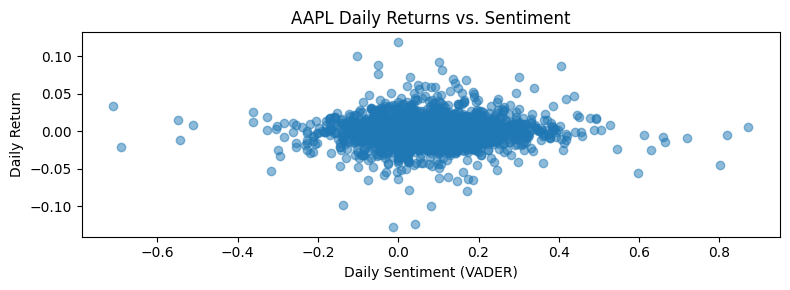

Processed AAPL in 0.45 seconds

Correlation between sentiment and AMZN daily returns: 0.0296


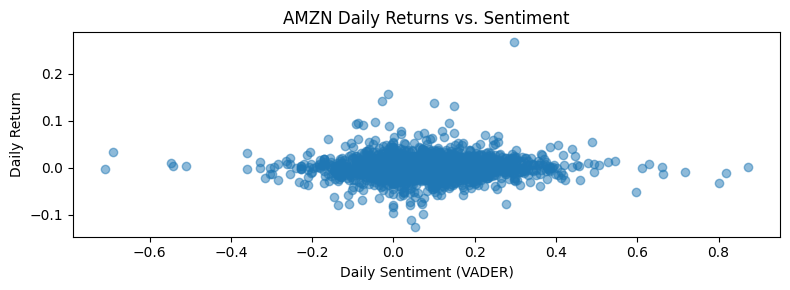

Processed AMZN in 0.38 seconds

Correlation between sentiment and GOOG daily returns: 0.0456


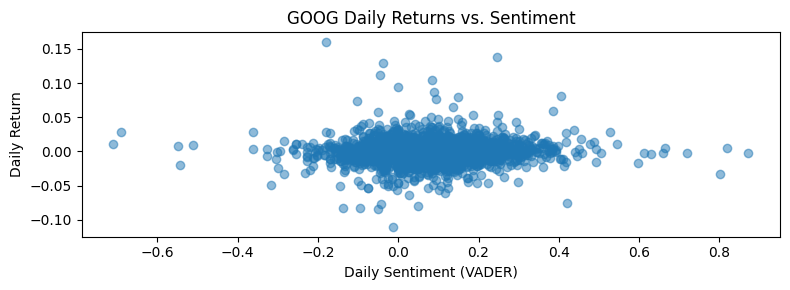

Processed GOOG in 0.45 seconds

Correlation between sentiment and META daily returns: 0.0479


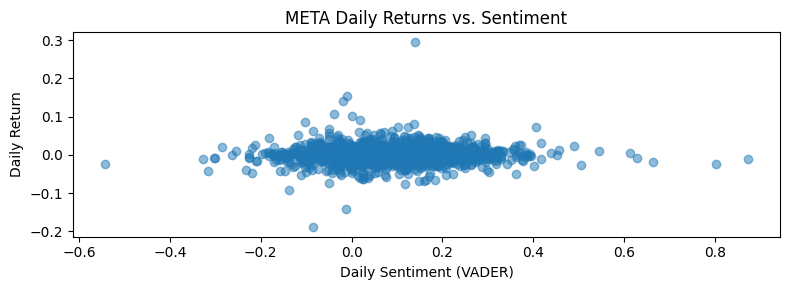

Processed META in 0.36 seconds

Correlation between sentiment and MSFT daily returns: 0.0352


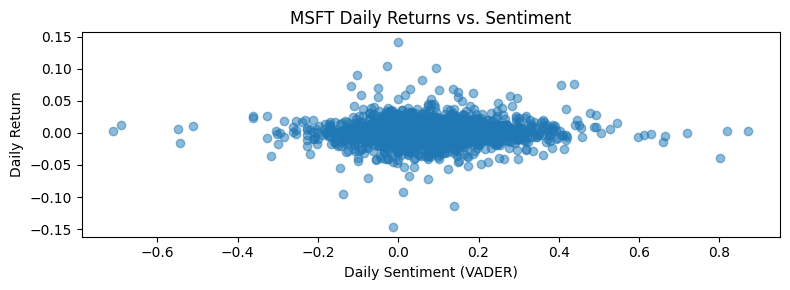

Processed MSFT in 0.35 seconds

Correlation between sentiment and NVDA daily returns: 0.0364


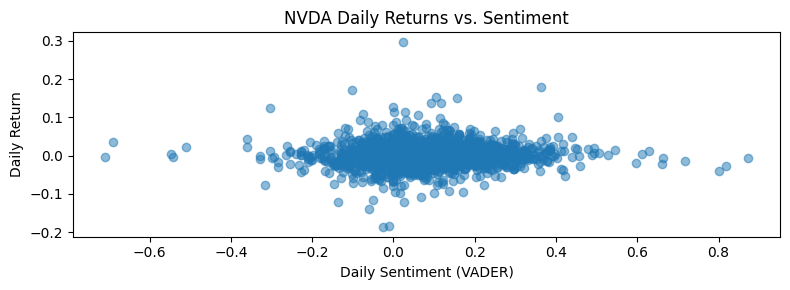

Processed NVDA in 0.39 seconds

Correlation between sentiment and TSLA daily returns: 0.0249


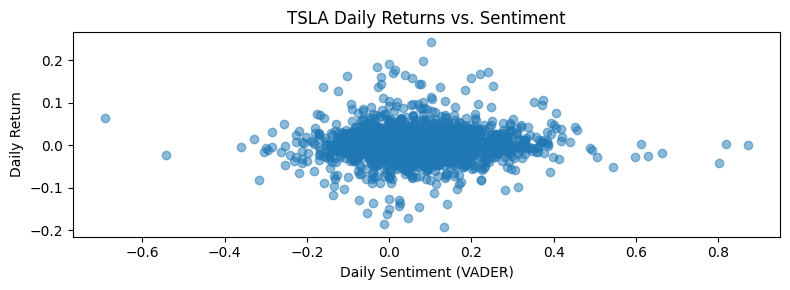

Processed TSLA in 0.34 seconds

Correlation Summary:
AAPL: 0.0238
AMZN: 0.0296
GOOG: 0.0456
META: 0.0479
MSFT: 0.0352
NVDA: 0.0364
TSLA: 0.0249


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
import os
import time

# Download VADER lexicon
nltk.download('vader_lexicon')

# Ensure notebooks directory exists
notebook_dir = os.path.join(os.getcwd(), 'notebooks')
os.makedirs(notebook_dir, exist_ok=True)

# Initialize VADER
sia = SentimentIntensityAnalyzer()

# Load FNSPID dataset
start_time = time.time()
try:
    df_news = pd.read_csv('../data/raw_analyst_ratings.csv')
    df_news = df_news.sample(n=20000, random_state=42) if len(df_news) > 20000 else df_news
    df_news['date'] = pd.to_datetime(df_news['date'], utc=True, errors='coerce')
    df_news['date_only'] = df_news['date'].dt.date
    df_news['date_only'] = pd.to_datetime(df_news['date_only'])  # Convert to datetime64
    print("News Dataset Info:")
    print(df_news.info())
except FileNotFoundError:
    print("Error: fnspid.csv not found in data/")
print(f"Loaded news data in {time.time() - start_time:.2f} seconds")

# Sentiment analysis
start_time = time.time()
df_news['sentiment'] = df_news['headline'].apply(lambda x: sia.polarity_scores(str(x))['compound'])
daily_sentiment = df_news.groupby('date_only')['sentiment'].mean().reset_index()
print(f"Sentiment analysis completed in {time.time() - start_time:.2f} seconds")

# Load stock data and correlate
tickers = ['AAPL', 'AMZN', 'GOOG', 'META', 'MSFT', 'NVDA', 'TSLA']
correlations = {}

for ticker in tickers:
    start_time = time.time()
    try:
        stock_data = pd.read_csv(f'data/processed/{ticker}_data.csv')
        stock_data['Date'] = pd.to_datetime(stock_data['Date'])
        stock_data['date_only'] = pd.to_datetime(stock_data['Date'].dt.date)  # Ensure datetime64
        stock_data['daily_return'] = stock_data['Close'].pct_change()

        merged_df = pd.merge(
            daily_sentiment,
            stock_data[['date_only', 'daily_return']],
            on='date_only',
            how='inner'
        )

        correlation = merged_df['sentiment'].corr(merged_df['daily_return'])
        correlations[ticker] = correlation
        print(f"\nCorrelation between sentiment and {ticker} daily returns: {correlation:.4f}")

        plt.figure(figsize=(8, 3))
        plt.scatter(merged_df['sentiment'], merged_df['daily_return'], alpha=0.5)
        plt.title(f'{ticker} Daily Returns vs. Sentiment')
        plt.xlabel('Daily Sentiment (VADER)')
        plt.ylabel('Daily Return')
        plt.tight_layout()
        plt.show()
        plt.savefig(os.path.join(notebook_dir, f'{ticker}_sentiment_vs_returns.png'), dpi=100)
        plt.close()

        print(f"Processed {ticker} in {time.time() - start_time:.2f} seconds")

    except FileNotFoundError:
        print(f"Error: {ticker}_data.csv not found in data/processed/")
    except Exception as e:
        print(f"Error processing {ticker}: {e}")

print("\nCorrelation Summary:")
for ticker, corr in correlations.items():
    print(f"{ticker}: {corr:.4f}")